In [38]:
# Cell 1: Imports and experiment configuration

import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import graphical_lasso, ledoit_wolf

%matplotlib widget
import matplotlib.pyplot as plt

TICKERS = pd.read_csv('tickers_names.csv')['Ticker'].tolist()

START_DATE = "2022-01-01"
END_DATE = "2024-01-01"

ALPHA = 0.4                      # Graphical Lasso regularization parameter
WINDOW_WEEKS = 4
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK  # approx 10 trading days

print("Config loaded.")
print("  n_tickers:", len(TICKERS))
print("  date range:", START_DATE, "->", END_DATE)
print("  WINDOW_SIZE (trading days):", WINDOW_SIZE)

Config loaded.
  n_tickers: 643
  date range: 2022-01-01 -> 2024-01-01
  WINDOW_SIZE (trading days): 20


In [39]:
# Cell 2: Data retrieval and returns computation

def get_data(tickers, start_date, end_date, min_coverage, fill_nan):
    """
    Downloads historical price data via Yahoo Finance, filters assets by 
    data availability, and returns a cleaned DataFrame of daily returns.

    Args:
        tickers (list): List of ticker names.
        start_date (str): Start date (YYYY-MM-DD).
        end_date (str): End date (YYYY-MM-DD).
        min_coverage (float): Minimum ratio of non-null data points required.

    Returns:
        pd.DataFrame: Cleaned daily returns for all qualified assets.
    """
    print("Downloading data from Yahoo Finance...")
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Close']

    if isinstance(data, pd.Series):
        data = data.to_frame()

    coverage = data.notna().mean(axis=0)
    keep = coverage[coverage >= min_coverage].index
    data = data[keep]

    print(f"Kept {data.shape[1]} / {len(tickers)} tickers with >= {min_coverage:.0%} coverage")

    # Forward fill NaN values with the last available price
    if fill_nan:
        data = data.fillna(method='ffill')
        print("Filled missing data with forward fill.")

    returns = data.pct_change(fill_method=None)
    days_before = len(returns)
    returns = returns.dropna(how="any")
    days_after = len(returns)
    print(f"Dropped {days_before - days_after} days with missing data; {days_after} days remain")

    print(f"✅ Retrieved {returns.shape[1]} assets over {returns.shape[0]} days")
    return returns

returns_df = get_data(TICKERS, START_DATE, END_DATE, min_coverage=0.95, fill_nan=True)


print("\nreturns_df info:")
print("  shape:", returns_df.shape)
print("  columns (tickers):", list(returns_df.columns))
print(returns_df.head())


[*********************100%***********************]  643 of 643 completed

6 Failed downloads:
['AZPN', 'HES', 'BKW.AX', 'ANSS', 'WBA', 'JNPR']: YFTzMissingError('possibly delisted; no timezone found')


Kept 582 / 643 tickers with >= 95% coverage
Filled missing data with forward fill.
Dropped 2 days with missing data; 518 days remain
✅ Retrieved 582 assets over 518 days

returns_df info:
  shape: (518, 582)
  columns (tickers): ['0KFE.IL', 'A', 'AAL.L', 'AAPL', 'ABBN.SW', 'ABT', 'AC.PA', 'AC8.MU', 'ACA.PA', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADS.DE', 'ADSK', 'AEE', 'AEG', 'AEM', 'AEP', 'AES', 'AFG', 'AFL', 'AFX.DE', 'AGCO', 'AGS.BR', 'AHT.L', 'AI.PA', 'AIR.PA', 'AKAM', 'ALB', 'ALGN', 'ALL', 'ALV.DE', 'AM.PA', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMP.MI', 'AMT', 'ANTO.L', 'ANZ.AX', 'AON', 'APA', 'APH', 'ARE', 'ARX.TO', 'ASM.AS', 'ASML', 'ASSA-B.ST', 'ASX', 'ATCO-B.ST', 'ATD.TO', 'ATO', 'AV.L', 'AVB', 'AVY', 'AXON', 'AXP', 'AZN', 'AZO', 'BA', 'BA.L', 'BAC', 'BAER.SW', 'BALL', 'BARC.L', 'BAS.DE', 'BAX', 'BAYN.DE', 'BBVA', 'BBY', 'BC8.DE', 'BCE.TO', 'BDX', 'BEI.DE', 'BEN', 'BESIY', 'BG', 'BIIB', 'BIRG.IR', 'BKNG', 'BKR', 'BLK', 'BMRN', 'BN.PA', 'BNP.PA', 'BNS', 'BOL.ST', 'BP', 'BRK-B', 'BSX'

C:\Users\nicco\AppData\Local\Temp\ipykernel_17108\2743805162.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [40]:
# Cell 3: Split the returns into fixed 2-week windows

def split_into_windows(returns_df, window_size):
    """
    Split the returns DataFrame into non-overlapping windows
    of length `window_size` along the time axis.
    """
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size  # floor division

    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        win = returns_df.iloc[start:end]
        windows.append(win)
    return windows

windows = split_into_windows(returns_df, WINDOW_SIZE)

print("Number of windows:", len(windows))
if len(windows) > 0:
    print("First window shape:", windows[0].shape)
    print("First window date range:", windows[0].index[0].date(), "->", windows[0].index[-1].date())
    print("Last window date range:", windows[-1].index[0].date(), "->", windows[-1].index[-1].date())


Number of windows: 25
First window shape: (20, 582)
First window date range: 2022-01-05 -> 2022-02-01
Last window date range: 2023-11-08 -> 2023-12-05


  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 3.617121906157987e+32
 Glasso Var. conditioning: 2.4654501334525594
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 4.919439981967322e+32
 Glasso Var. conditioning: 19.996721870071315
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 9.768877643506665e+32
 Glasso Var. conditioning: 86.07575974147069
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 4.052699837693091e+32
 Glasso Var. conditioning: 9.255736639935694
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 5.059769657505606e+32
 Glasso Var. conditioning: 136.57499668912791
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 4.6506064700724625e+33
 Glasso Var. conditioning: 481.63245776679173
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 5.654060029267941e+33
 Glasso Var. conditioning: 66.22095670768904
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 2.7839041880362486e+33
 Glasso Var. conditioning: 2.779892599944191
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(
c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:192: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.564e-03
  warnings.warn(


Sample Var. conditioning: 8.067899362877341e+33
 Glasso Var. conditioning: 283.79595473471306
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 8.145427748547251e+34
 Glasso Var. conditioning: 145.0074382509486
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 1.9653921361914792e+33
 Glasso Var. conditioning: 58.70585987984553
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 1.3346623649647307e+33
 Glasso Var. conditioning: 28.446587478098387
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 4.594764300237719e+33
 Glasso Var. conditioning: 75.66649939277686
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 2.269760685520381e+33
 Glasso Var. conditioning: 4.820357563608149
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 4.569243194575696e+33
 Glasso Var. conditioning: 1.8845209736410355
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 9.687204075217319e+33
 Glasso Var. conditioning: 178.6766424800363
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 2.83982671186276e+33
 Glasso Var. conditioning: 1.7382177907240979
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 7.117352628604085e+32
 Glasso Var. conditioning: 2.343312887285606
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 2.247730581053129e+33
 Glasso Var. conditioning: 5.216715000690244
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 5.9767766403422934e+32
 Glasso Var. conditioning: 4.070029498634864
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 9.296750554281093e+33
 Glasso Var. conditioning: 1.405815746018716
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 9.246750769769763e+32
 Glasso Var. conditioning: 1.8729092683976838
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 6.974310466048046e+33
 Glasso Var. conditioning: 7.117624279101702
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 1.221699034269279e+33
 Glasso Var. conditioning: 6.736940302677804
  Details: Singular matrix


c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:140: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  coefs, _, _, _ = cd_fast.enet_coordinate_descent_gram(


Sample Var. conditioning: 3.6638986453925956e+34
 Glasso Var. conditioning: 1.6952436734183012
Covariance and precision matrices computed.
  number of windows: 25
  covariance matrix shape: (582, 582)


C:\Users\nicco\AppData\Local\Temp\ipykernel_17108\631029632.py:118: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\nicco\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipympl\backend_nbagg.py:342: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


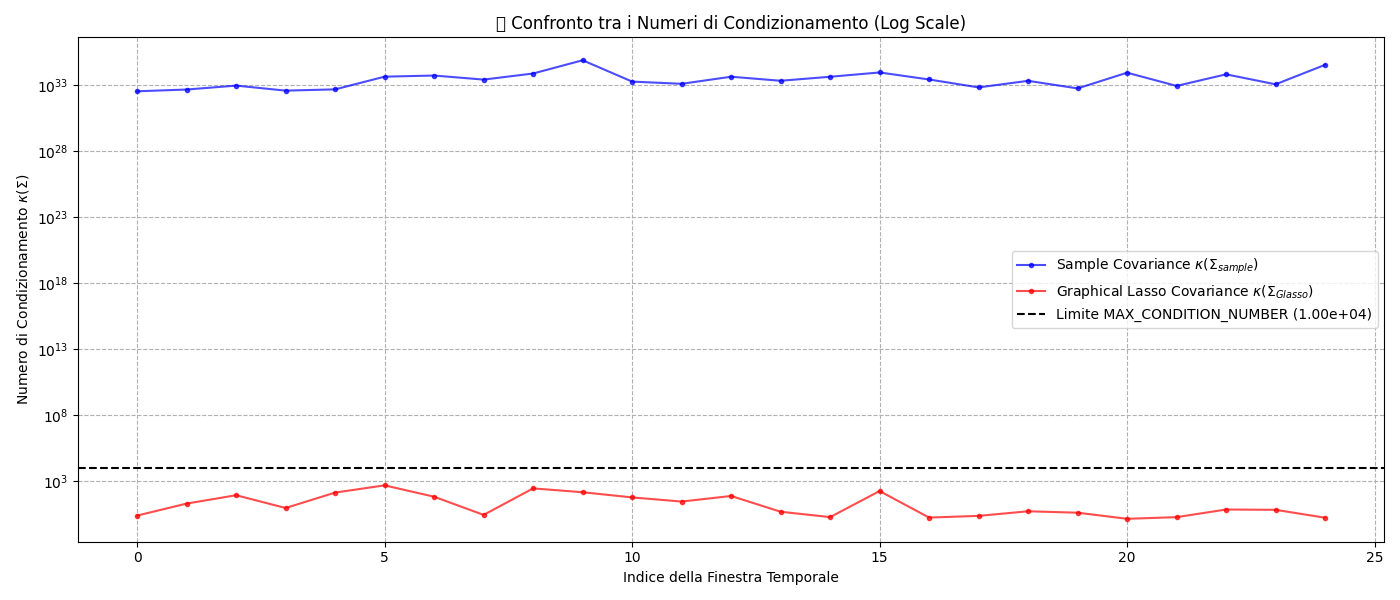


--- Analisi Dettagliata del Condizionamento ---
Limite MAX_CONDITION_NUMBER utilizzato: 1.00e+04
Numero totale di finestre: 25
----------------------------------------
Finestre mal condizionate (Campione): 25 (100.00%)
Finestre mal condizionate (Glasso): 0 (0.00%)


In [41]:
# Cell 4: Covariance and precision estimation per window (sample and Glasso)
# Adds a condition-number check before attempting to invert the sample covariance.

MAX_CONDITION_NUMBER = 1e4  # threshold to consider a matrix "well-conditioned"


def compute_cov_prec_for_window(window_returns, alpha):
    """
    Given a returns window (T x N), standardize it, then:
    - compute the sample covariance of standardized data
    - compute the inverse (precision) of the sample covariance, but only if it is
      sufficiently well-conditioned (based on the condition number)
    - compute a Ledoit–Wolf covariance for input to Graphical Lasso
    - apply Graphical Lasso to obtain a regularized covariance + precision

    Returns
    -------
    sample_cov : (N, N) ndarray
        Sample covariance matrix of standardized returns.
    sample_prec : (N, N) ndarray or None
        Inverse (precision) of sample_cov. Uses pseudo-inverse if poorly conditioned,
        or None if even pseudo-inverse fails.
    glasso_cov : (N, N) ndarray
        Covariance matrix estimated by Graphical Lasso.
    glasso_prec : (N, N) ndarray
        Precision matrix estimated by Graphical Lasso.
    """
    # --- STANDARDIZE RETURNS IN THE WINDOW ---
    scaler = StandardScaler()
    X = scaler.fit_transform(window_returns.values)  # shape: (T, N)

    # --- UNREGULARIZED SAMPLE COVARIANCE ---
    sample_cov = np.cov(X, rowvar=False)  # shape: (N, N)

    # --- CONDITION NUMBER CHECK ---
    try:
        cond_sample = np.linalg.cond(sample_cov) # 2-norm, computed directly using the SVD
    except np.linalg.LinAlgError as e:
        print(
            "Warning: could not compute condition number for sample covariance "
            f"in this window. Treating it as ill-conditioned.\n  Details: {e}"
        )
        cond_sample = np.inf

    sample_prec = None
    # is_well_conditioned = np.isfinite(cond_sample) and cond_sample < MAX_CONDITION_NUMBER

    try:
        sample_prec = np.linalg.inv(sample_cov)
    except np.linalg.LinAlgError as e:
        print(
            "Warning:"
            f"(cond={cond_sample:.2e}) and inversion failed;\n"
            f"  Details: {e}"
        )
        sample_prec = None


    # --- LEDOIT–WOLF COVARIANCE FOR GLASSO INPUT ---
    # We use standardized data and assume it is centered.
    emp_cov, _ = ledoit_wolf(X, assume_centered=True)

    # --- GRAPHICAL LASSO ---
    glasso_cov, glasso_prec = graphical_lasso(emp_cov, alpha=alpha, tol=1e-4)
    
    cond_glasso = np.linalg.cond(glasso_cov)
    
    print(f"Sample Var. conditioning: {cond_sample}\n Glasso Var. conditioning: {cond_glasso}")

    return sample_cov, cond_sample, sample_prec, glasso_cov, cond_glasso, glasso_prec


# Run estimation on all windows
sample_covs = []
sample_precs = []   # list of sample precision matrices (or None)
cond_sample = []
glasso_covs = []
glasso_precs = []   # list of Glasso precision matrices
cond_glasso = []

for idx, win in enumerate(windows):
    s_cov, s_cond, s_prec, g_cov, g_cond, g_prec = compute_cov_prec_for_window(win, ALPHA)
    sample_covs.append(s_cov)
    cond_sample.append(s_cond)
    sample_precs.append(s_prec)
    glasso_covs.append(g_cov)
    cond_glasso.append(g_cond)
    glasso_precs.append(g_prec)

print("Covariance and precision matrices computed.")
print("  number of windows:", len(sample_covs))
if len(sample_covs) > 0:
    print("  covariance matrix shape:", sample_covs[0].shape)
    

# --- 2. Funzione di Plotting e Analisi ---

window_indices = np.arange(len(cond_sample))

plt.figure(figsize=(14, 6))

# Plot dei valori di condizionamento campionari
plt.plot(window_indices, cond_sample, label='Sample Covariance $\\kappa(\\Sigma_{sample})$', marker='.', linestyle='-', color='blue', alpha=0.7)

# Plot dei valori di condizionamento Glasso
plt.plot(window_indices, cond_glasso, label='Graphical Lasso Covariance $\\kappa(\\Sigma_{Glasso})$', marker='.', linestyle='-', color='red', alpha=0.7)

# Linea orizzontale per il limite di mal condizionamento
plt.axhline(MAX_CONDITION_NUMBER, color='k', linestyle='--', label=f'Limite MAX_CONDITION_NUMBER ({MAX_CONDITION_NUMBER:.2e})')

# Impostazioni del grafico
plt.yscale('log') # Usa una scala logaritmica per vedere i grandi valori
plt.title('📈 Confronto tra i Numeri di Condizionamento (Log Scale)')
plt.xlabel('Indice della Finestra Temporale')
plt.ylabel('Numero di Condizionamento $\\kappa(\\Sigma)$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.show()

# --- 3. Analisi del Condizionamento ---

# Controlla per i valori mal condizionati (condizionamento > Limite)
num_windows = len(window_indices)
num_sample_ill = np.sum(np.array(cond_sample) > MAX_CONDITION_NUMBER)
num_glasso_ill = np.sum(np.array(cond_glasso) > MAX_CONDITION_NUMBER)

print("\n--- Analisi Dettagliata del Condizionamento ---")
print(f"Limite MAX_CONDITION_NUMBER utilizzato: {MAX_CONDITION_NUMBER:.2e}")
print(f"Numero totale di finestre: {num_windows}")
print("-" * 40)
print(f"Finestre mal condizionate (Campione): {num_sample_ill} ({num_sample_ill / num_windows * 100:.2f}%)")
print(f"Finestre mal condizionate (Glasso): {num_glasso_ill} ({num_glasso_ill / num_windows * 100:.2f}%)")


In [42]:
# Cell 5: Frobenius norm differences across consecutive windows

def frobenius_differences(cov_list):
    """
    Compute Frobenius norm of differences between consecutive
    covariance matrices in `cov_list`.
    """
    diffs = []
    for i in range(len(cov_list) - 1):
        delta = (cov_list[i+1] - cov_list[i])
        frob = np.linalg.norm(delta, ord='fro')/np.linalg.norm(cov_list[i], ord='fro')    # NORMALIZATION
        diffs.append(frob)
    return np.array(diffs)

fro_sample = frobenius_differences(sample_covs)
fro_glasso = frobenius_differences(glasso_covs)

# Build a DataFrame for easier inspection
window_pairs = []
for i in range(len(windows) - 1):
    w1 = windows[i]
    w2 = windows[i+1]
    label = f"{w1.index[0].date()}–{w1.index[-1].date()} -> {w2.index[0].date()}–{w2.index[-1].date()}"
    window_pairs.append(label)

results_df = pd.DataFrame({
    "window_pair": window_pairs,
    "frobenius_sample": fro_sample,
    "frobenius_glasso": fro_glasso,
})

print("Frobenius differences between consecutive windows:")
print(results_df.head())
print("\nSummary statistics:")
print("  mean(sample) :", results_df["frobenius_sample"].mean())
print("  mean(glasso) :", results_df["frobenius_glasso"].mean())
print("  std(sample)  :", results_df["frobenius_sample"].std())
print("  std(glasso)  :", results_df["frobenius_glasso"].std())


Frobenius differences between consecutive windows:
                                      window_pair  frobenius_sample  \
0  2022-01-05–2022-02-01 -> 2022-02-02–2022-03-01          1.096426   
1  2022-02-02–2022-03-01 -> 2022-03-02–2022-03-29          0.910960   
2  2022-03-02–2022-03-29 -> 2022-03-30–2022-04-26          0.861227   
3  2022-03-30–2022-04-26 -> 2022-04-27–2022-05-24          0.889891   
4  2022-04-27–2022-05-24 -> 2022-05-25–2022-06-21          0.713574   

   frobenius_glasso  
0          0.398881  
1          0.965474  
2          0.735168  
3          1.555562  
4          1.411425  

Summary statistics:
  mean(sample) : 0.9176756824903425
  mean(glasso) : 0.6869396722878146
  std(sample)  : 0.19465448129028237
  std(glasso)  : 0.7051200996474246


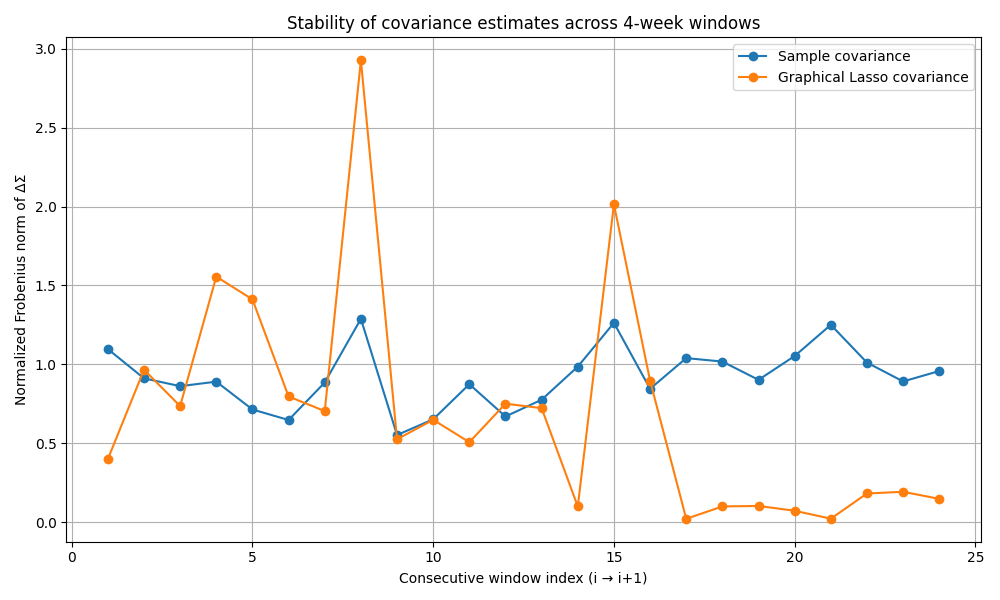

Stability comparison plot generated.


In [43]:
# Cell 6: Plot sample vs Glasso Frobenius norms

plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample) + 1)

plt.plot(x, fro_sample, marker='o', label="Sample covariance")
plt.plot(x, fro_glasso, marker='o', label="Graphical Lasso covariance")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Normalized Frobenius norm of ΔΣ")
plt.title(f"Stability of covariance estimates across {WINDOW_WEEKS}-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Stability comparison plot generated.")


In [44]:
# Cell 7: Frobenius norm differences for precision matrices (sample vs Glasso)

# Reuse the same helper; it works for any list of matrices (covariances or precisions)
fro_sample_prec = frobenius_differences(sample_precs)
fro_glasso_prec = frobenius_differences(glasso_precs)

# Label window pairs i -> i+1
window_pairs_prec = [f"{i}→{i+1}" for i in range(len(fro_sample_prec))]

prec_results_df = pd.DataFrame({
    "window_pair": window_pairs_prec,
    "frobenius_sample_prec": fro_sample_prec,
    "frobenius_glasso_prec": fro_glasso_prec,
})

print("Frobenius differences between consecutive windows (PRECISION matrices):")
print(prec_results_df.head())

print("\nSummary statistics for precision matrices:")
print("  mean(sample precision) :", prec_results_df["frobenius_sample_prec"].mean())
print("  mean(glasso precision) :", prec_results_df["frobenius_glasso_prec"].mean())
print("  std(sample precision)  :", prec_results_df["frobenius_sample_prec"].std())
print("  std(glasso precision)  :", prec_results_df["frobenius_glasso_prec"].std())

# Plot the stability over window pairs
plt.figure(figsize=(10, 6))
x = np.arange(1, len(fro_sample_prec) + 1)

plt.plot(x, fro_sample_prec, marker='o', label="Sample precision")
plt.plot(x, fro_glasso_prec, marker='o', label="Graphical Lasso precision")

plt.xlabel("Consecutive window index (i → i+1)")
plt.ylabel("Frobenius norm of ΔΘ  (precision)")
plt.title("Stability of precision estimates across 2-week windows")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("Precision stability comparison plot generated.")


print(fro_sample_prec)
print(fro_glasso_prec)


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

**Interpretation**: Why Condition Number Drives Stability

In our code, we calculated $\kappa_2(\Sigma)$ using np.linalg.cond, which computes the ratio of the largest to the smallest singular value via SVD ($\sigma_{max} / \sigma_{min}$).

When we move from window $t$ to $t+1$, the input covariance matrix $\Sigma$ changes slightly (perturbation). The condition number tells us how much that small change is amplified when we compute the inverse (Precision Matrix $\Omega = \Sigma^{-1}$).The theoretical bound on relative error is:$$\frac{\|\Delta \Sigma^{-1}\|}{\|\Sigma^{-1}\|} \leq \kappa(\Sigma) \cdot \frac{\|\Delta \Sigma\|}{\|\Sigma\|}$$

**Numerical Example from Our Results**:
1. When $\kappa_2(\Sigma)$ ~20,000: a tiny $5\%$ change in the input data (rolling the window forward) can be amplified up to $20,000 \times 0.05 = 1,000$ times (100,000%) in the inverse matrix. This explains why our consecutive Frobenius differences for the sample precision are massive (mean ~1,272). The solution is numerically unstable and jumps wildly.
2. The Graphical Lasso (Well-Conditioned): The regularization forced $\kappa$ down to ~2 to 5.The Mechanism: With a $\kappa \approx 3$, a $5\%$ change in input results in only a $3 \times 0.05 = 0.15$ (15%) change in the inverse. 

Observed Result: Our observed Frobenius differences are very small. The estimate is robust and evolves smoothly over time.

In [ ]:
# Cell 8: Markowitz Portfolio Performance: Window t -> Window t+1
# Compare Markowitz using sample covariance vs Glasso covariance

def min_variance_portfolio(Theta):
    """Minimum-variance portfolio under 1'w = 1, with short-selling allowed.
    Uses only the precision matrix (doesn't need mean returns)."""
    ones = np.ones(Theta.shape[0])
    A = ones @ Theta @ ones
    if A <= 0:
        raise ValueError("A <= 0: precision matrix may be invalid")
    w_mv = Theta @ ones / A
    return w_mv

def portfolio_returns(w, returns_df):
    """Compute portfolio returns for each day in returns_df.
    
    Args:
        w: (N,) portfolio weights
        returns_df: DataFrame with shape (T, N) where T is number of days, N is number of assets
    
    Returns:
        (T,) array of portfolio returns
    """
    # Ensure w is aligned with returns_df columns
    if isinstance(returns_df, pd.DataFrame):
        # If w is a Series with index, align it
        if isinstance(w, pd.Series):
            w_aligned = w.reindex(returns_df.columns, fill_value=0.0).values
        else:
            # Assume same order
            w_aligned = w
        return (returns_df.values @ w_aligned).flatten()
    else:
        return (returns_df @ w).flatten()

# Storage for results
results = {
    'window_idx': [],
    'sample_cumulative_return': [],
    'glasso_cumulative_return': [],
    'sample_sharpe': [],
    'glasso_sharpe': [],
    'sample_volatility': [],
    'glasso_volatility': [],
    'sample_mean_return': [],
    'glasso_mean_return': [],
}

print("Computing Markowitz portfolios and evaluating on next window...")
print("="*60)

# Iterate over windows (skip last window as there's no t+1)
for t in range(len(windows) - 1):
    window_t = windows[t]
    window_t1 = windows[t + 1]
    
    # Verify that windows have the same assets (they should, but check anyway)
    if not window_t.columns.equals(window_t1.columns):
        print(f"Warning: Window {t} and {t+1} have different assets. Finding common assets...")
        common_cols = window_t.columns.intersection(window_t1.columns)
        if len(common_cols) < 2:
            print(f"  Insufficient common assets ({len(common_cols)}). Skipping window {t}.")
            continue
        window_t = window_t[common_cols]
        window_t1 = window_t1[common_cols]
        # Note: This means we'd need to recompute covariances, but for simplicity,
        # we'll assume this case is rare and skip it
        print(f"  Found {len(common_cols)} common assets. Skipping for now (would need to recompute covariances).")
        continue
    
    # Get precision matrices for window t
    sample_prec_t = sample_precs[t]
    glasso_prec_t = glasso_precs[t]
    
    # Check if sample precision is available (might be None if ill-conditioned)
    if sample_prec_t is None:
        # Use pseudo-inverse as fallback
        try:
            sample_cov_t = sample_covs[t]
            sample_prec_t = np.linalg.pinv(sample_cov_t)
            print(f"Window {t}: Using pseudo-inverse for sample precision (ill-conditioned)")
        except Exception as e:
            print(f"Window {t}: Could not compute sample precision. Error: {e}. Skipping.")
            continue
    
    # Calculate minimum-variance portfolios using window t precision matrices
    try:
        w_sample = min_variance_portfolio(sample_prec_t)
        w_glasso = min_variance_portfolio(glasso_prec_t)
    except Exception as e:
        print(f"Window {t}: Error computing portfolios: {e}. Skipping.")
        continue
    
    # Apply portfolios to window t+1 returns
    # Convert weights to Series for proper alignment
    w_sample_series = pd.Series(w_sample, index=window_t.columns)
    w_glasso_series = pd.Series(w_glasso, index=window_t.columns)
    
    portfolio_ret_sample = portfolio_returns(w_sample_series, window_t1)
    portfolio_ret_glasso = portfolio_returns(w_glasso_series, window_t1)
    
    # Calculate performance metrics
    # Cumulative return (product of (1 + daily returns))
    cumret_sample = np.prod(1 + portfolio_ret_sample) - 1
    cumret_glasso = np.prod(1 + portfolio_ret_glasso) - 1
    
    # Mean return and volatility (daily)
    meanret_sample = np.mean(portfolio_ret_sample)
    meanret_glasso = np.mean(portfolio_ret_glasso)
    vol_sample = np.std(portfolio_ret_sample)
    vol_glasso = np.std(portfolio_ret_glasso)
    
    # Sharpe ratio (assuming risk-free rate = 0 for simplicity)
    rf_daily = 0.0
    sharpe_sample = (meanret_sample - rf_daily) / vol_sample if vol_sample > 1e-10 else 0.0
    sharpe_glasso = (meanret_glasso - rf_daily) / vol_glasso if vol_glasso > 1e-10 else 0.0
    
    # Store results
    results['window_idx'].append(t)
    results['sample_cumulative_return'].append(cumret_sample)
    results['glasso_cumulative_return'].append(cumret_glasso)
    results['sample_sharpe'].append(sharpe_sample)
    results['glasso_sharpe'].append(sharpe_glasso)
    results['sample_volatility'].append(vol_sample)
    results['glasso_volatility'].append(vol_glasso)
    results['sample_mean_return'].append(meanret_sample)
    results['glasso_mean_return'].append(meanret_glasso)
    
    if (t + 1) % 5 == 0 or t == 0:
        print(f"Window {t} -> {t+1}: Sample cumret={cumret_sample:.4f}, Glasso cumret={cumret_glasso:.4f}")

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(results)

if len(results_df) == 0:
    print("\n⚠️  No results computed. Check for errors above.")
else:
    print("\n" + "="*60)
    print("Summary Statistics:")
    print("="*60)
    print(f"\nSample Covariance Portfolios:")
    print(f"  Mean cumulative return: {results_df['sample_cumulative_return'].mean():.6f}")
    print(f"  Std cumulative return:  {results_df['sample_cumulative_return'].std():.6f}")
    print(f"  Mean Sharpe ratio:       {results_df['sample_sharpe'].mean():.4f}")
    print(f"  Mean volatility:         {results_df['sample_volatility'].mean():.6f}")
    
    print(f"\nGlasso Covariance Portfolios:")
    print(f"  Mean cumulative return: {results_df['glasso_cumulative_return'].mean():.6f}")
    print(f"  Std cumulative return:  {results_df['glasso_cumulative_return'].std():.6f}")
    print(f"  Mean Sharpe ratio:       {results_df['glasso_sharpe'].mean():.4f}")
    print(f"  Mean volatility:         {results_df['glasso_volatility'].mean():.6f}")
    
    # Plot results
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Cumulative Returns
    ax1 = axes[0, 0]
    x = results_df['window_idx']
    ax1.plot(x, results_df['sample_cumulative_return'], marker='o', label='Sample Covariance', 
             linewidth=2, markersize=6, color='blue', alpha=0.7)
    ax1.plot(x, results_df['glasso_cumulative_return'], marker='s', label='Glasso Covariance', 
             linewidth=2, markersize=6, color='red', alpha=0.7)
    ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax1.set_xlabel('Window Index (t)')
    ax1.set_ylabel('Cumulative Return in Window t+1')
    ax1.set_title('Cumulative Returns: Portfolio from Window t → Applied to Window t+1')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Sharpe Ratios
    ax2 = axes[0, 1]
    ax2.plot(x, results_df['sample_sharpe'], marker='o', label='Sample Covariance', 
             linewidth=2, markersize=6, color='blue', alpha=0.7)
    ax2.plot(x, results_df['glasso_sharpe'], marker='s', label='Glasso Covariance', 
             linewidth=2, markersize=6, color='red', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax2.set_xlabel('Window Index (t)')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.set_title('Sharpe Ratios: Portfolio from Window t → Applied to Window t+1')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Volatilities
    ax3 = axes[1, 0]
    ax3.plot(x, results_df['sample_volatility'], marker='o', label='Sample Covariance', 
             linewidth=2, markersize=6, color='blue', alpha=0.7)
    ax3.plot(x, results_df['glasso_volatility'], marker='s', label='Glasso Covariance', 
             linewidth=2, markersize=6, color='red', alpha=0.7)
    ax3.set_xlabel('Window Index (t)')
    ax3.set_ylabel('Volatility (Std Dev)')
    ax3.set_title('Portfolio Volatilities: Portfolio from Window t → Applied to Window t+1')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Mean Returns
    ax4 = axes[1, 1]
    ax4.plot(x, results_df['sample_mean_return'], marker='o', label='Sample Covariance', 
             linewidth=2, markersize=6, color='blue', alpha=0.7)
    ax4.plot(x, results_df['glasso_mean_return'], marker='s', label='Glasso Covariance', 
             linewidth=2, markersize=6, color='red', alpha=0.7)
    ax4.axhline(0, color='black', linestyle='--', alpha=0.3)
    ax4.set_xlabel('Window Index (t)')
    ax4.set_ylabel('Mean Daily Return')
    ax4.set_title('Mean Returns: Portfolio from Window t → Applied to Window t+1')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot: Cumulative performance over all windows
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate cumulative product of (1 + return) for each window
    cumulative_sample = np.cumprod(1 + results_df['sample_cumulative_return'])
    cumulative_glasso = np.cumprod(1 + results_df['glasso_cumulative_return'])
    
    ax.plot(x, cumulative_sample, marker='o', label='Sample Covariance (Cumulative)', 
            linewidth=2.5, markersize=8, color='blue', alpha=0.8)
    ax.plot(x, cumulative_glasso, marker='s', label='Glasso Covariance (Cumulative)', 
            linewidth=2.5, markersize=8, color='red', alpha=0.8)
    ax.axhline(1, color='black', linestyle='--', alpha=0.3, label='Break-even')
    ax.set_xlabel('Window Index (t)')
    ax.set_ylabel('Cumulative Performance (1 + Return)')
    ax.set_title('Cumulative Performance Over All Windows\n(Portfolio from Window t → Applied to Window t+1)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Markowitz portfolio performance analysis complete!")
